### Protein quantification by MaxQuant MBR+ and peptideprotonet+PIP in a hybrid Human, E.coli and Yeast proteome

In [ ]:
# requires(c('FNN','dplyr','matrixStats', 'limma', 'msImpute'))

#### Load saved embeddings and preprocess

In [1]:
query_embedding <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_TenzerHYE_noEvidenceTrain.csv')

refrence_data <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_EvidenceTrain.csv')


refrence_data$Leading.razor.protein <- paste(refrence_data$Leading.razor.protein,
                                             refrence_data$Species, sep = "_")

refrence_data$PrecursorID <- gsub("__","_", refrence_data$PrecursorID)
refrence_data$PrecursorID <- paste(refrence_data$PrecursorID, 
                                   refrence_data$Leading.razor.protein,
                                   sep="_")

tcells_evidence <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/Tenzer_txt/evidence.txt")

# keep only MSMS evidence
tcells_evidence <- tcells_evidence[tcells_evidence$Type %in% "TIMS-MULTI-MSMS",]
tcells_evidence$PrecursorID <- paste(paste(tcells_evidence$Modified.sequence, 
                                     tcells_evidence$Charge,
                                     sep=""),
                                     tcells_evidence$Leading.razor.protein,
                                     sep="_")




tcells_evidence$Species <- "HYE"

query <- query_embedding # grep("dim|Raw.file", colnames(data))
reference <- refrence_data #  grep("dim", colnames(data))
query$Raw.file.id <- as.numeric(as.factor(query$Raw.file))
tcells_evidence$Raw.file.id <- as.numeric(as.factor(tcells_evidence$Raw.file))




lc_ms_anchors  <- c("Raw.file.id", "Charge","m.z", "Mass", "Intensity","Retention.time")
tcells_evidence <- tcells_evidence[complete.cases(tcells_evidence[, lc_ms_anchors]),]

identified_peptides <- FNN::get.knnx(query[, lc_ms_anchors], tcells_evidence[, lc_ms_anchors], k=1)
identified_peptides <- query[identified_peptides$nn.index,]
identified_peptides$PrecursorID <- tcells_evidence$PrecursorID
identified_peptides$Species <- tcells_evidence$Species


unidentified_peptides <- dplyr::anti_join(query, identified_peptides,
                                            by = lc_ms_anchors)



reference_combined <- rbind(reference[,c(grep("dim", colnames(reference), value = TRUE), "Charge", "PrecursorID", "Species")],
                            identified_peptides[,c(grep("dim", colnames(reference), value = TRUE), "Charge" ,"PrecursorID", "Species")])
                            
unidentified_peptides_latent <- unidentified_peptides[, grep("dim", colnames(unidentified_peptides))]


reference_latent <- reference_combined[, grep("dim", colnames(reference_combined))]
reference_charge <- reference_combined$Charge
reference_ident_labels <- reference_combined$PrecursorID
reference_ident_species <- reference_combined$Species


all_unidentified_peptides <- unidentified_peptides

In [2]:
reference_combined_sub <- reference_combined[reference_combined$Species %in% c("HeLa","Yeast", "Ecoli"), ] # c("HeLa","Human","Yeast")

# reference_combined_sub <- reference_combined
reference_latent <- reference_combined_sub[, grep("dim", colnames(reference_combined_sub))]
reference_charge <- reference_combined_sub$Charge
reference_ident_labels <- reference_combined_sub$PrecursorID
reference_ident_species <- reference_combined_sub$Species




study_embedding <- reference_combined[reference_combined$Species %in% c("HYE"), ] # c("HeLa","Human","Yeast")
study_latent <- study_embedding[, grep("dim", colnames(study_embedding))]
study_charge <- study_embedding$Charge
study_ident_labels <- study_embedding$PrecursorID
study_ident_species <- study_embedding$Species






tcells_evidence_dedupped <- tcells_evidence[, c("Raw.file","PrecursorID")]
tcells_evidence_dedupped <- tcells_evidence_dedupped[!duplicated(tcells_evidence_dedupped),]
# tcells_evidence_dedupped <- tcells_evidence_dedupped[grep("ox|Deamidation|Acetyl|Oxidation|ac", tcells_evidence_dedupped$PrecursorID, invert=TRUE),]

#### Identity propagation step

`computeStats()` function performs the propagation step and computes summary statistics, including false transfers, new identifications and coverage before and after transfer

In [3]:
computeStats <- function(thr, k){
  
  # false_transfer_rate <- c()
  # coverage_per_run <- c()
  total_idents_per_run_after_transfer <- c()
  number_new_ident <- c()
  coverage_per_run_after_transfer <- c()
  coverage_per_run_before_transfer <- c()
  ident_list <- list()
  
  itr = 1
  
  for (run in unique(tcells_evidence_dedupped$Raw.file)){
    
    message(run)
    missing_idents <- setdiff(tcells_evidence_dedupped$PrecursorID,
                              tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file == run])
  
    latent_study <- study_latent[study_embedding$PrecursorID %in% missing_idents,]
    s_charge <- study_charge[study_embedding$PrecursorID %in% missing_idents]
    s_ident_labels <- study_ident_labels[study_embedding$PrecursorID %in% missing_idents]
    s_ident_species <- study_ident_species[study_embedding$PrecursorID %in% missing_idents]
  
  
    run_query_peptides <- unidentified_peptides[unidentified_peptides$Raw.file %in% run,]
  
    run_query_peptides_latent <- run_query_peptides[, grep("dim", colnames(run_query_peptides))]
    #run_query_peptides_latent <- t(apply(run_query_peptides_latent, 1, FUN=function(x) x/sqrt(sum(x^2))))
    query_feature_charges <- run_query_peptides$Charge
    run_query_peptides_intensity <- run_query_peptides$Intensity
  
  
    knn_prototypes <- FNN::get.knnx(

        latent_study,
        run_query_peptides_latent,
      k = k) 
  
    probs <- exp(-0.5*((knn_prototypes$nn.dist^2)/matrixStats::rowSds(knn_prototypes$nn.dist^2)))
    # probs <- 1 - knn_prototypes$nn.dist^2
    ww <- matrix(s_charge[knn_prototypes$nn.index], nrow = nrow(probs), ncol = ncol(probs))
    charge <- matrix(query_feature_charges, nrow = nrow(ww), ncol = ncol(ww), byrow = FALSE)
    w <- ifelse(ww==charge, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(s_ident_labels[knn_prototypes$nn.index], 
                               nrow = nrow(probs), ncol = ncol(probs))
    transferred_species <- matrix(s_ident_species[knn_prototypes$nn.index], 
                                nrow = nrow(probs), ncol = ncol(probs))


    # probs <- w*probs
    # probs <- probs/rowSums(probs)
    # probs[!is.finite(probs)] <- 0

    transferred_idents[w==0] <- "other"
    transferred_species[w==0] <- "other"


    unmapped_queries <- (rowSums(probs < thr) == k)
    
    # false_transfers_co <- which(rowSums(probs >= thr & transferred_species == c("Yeast") ) > 1)
    # length(false_transfers_co)
  
  
    correct_transfers <-  (rowSums(probs >= thr & (transferred_species == "HYE") )> 2) # | transferred_species == "HeLa"
    correct_transfers_run_names <- run_query_peptides$Raw.file[correct_transfers]
    correct_transfer_idents <- transferred_idents[correct_transfers,]
    correct_transfer_idents <- apply(correct_transfer_idents,1, FUN=function(x) {
      z <- table(x)
      z <- z[!grepl("other", names(z))]
      names(z)[which.max(z)]}
      )
  
    correct_transfer_idents <- gsub("__","_",correct_transfer_idents)
    transfer_idents <- do.call(cbind, list(correct_transfers_run_names, correct_transfer_idents,
                                           run_query_peptides_intensity[correct_transfers]))
    transfer_idents <- data.frame(transfer_idents)
    colnames(transfer_idents) <- c("Raw.file","PrecursorID","Intensity")
    transfer_idents$PrecursorID <- gsub("__","_", transfer_idents$PrecursorID)
  
    
    
    ### computation of false transfers-------
    
    # false_transfer_rate[itr] <- length(false_transfers)
    
    query_feature_charges <- run_query_peptides$Charge[unmapped_queries]
    unmapped_queries_latent <- run_query_peptides_latent[unmapped_queries,]
    unmapped_queries_inetnsity <- run_query_peptides_intensity[unmapped_queries]
    
    if(nrow(unmapped_queries_latent) > 0 ) {
      
      
      ex_prototypes <- FNN::get.knnx(

        reference_latent,
        unmapped_queries_latent,
      k = k) 
  
    ex_probs <- exp(-0.5*((ex_prototypes$nn.dist^2)/matrixStats::rowSds(ex_prototypes$nn.dist^2)))
    # ex_probs <- 1 - ex_prototypes$nn.dist^2
    ww2 <- matrix(reference_charge[ex_prototypes$nn.index], nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    charge_ex <- matrix(query_feature_charges, nrow = nrow(ww2), ncol = ncol(ww2), byrow = FALSE)
    w2 <- ifelse(ww2==charge_ex, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(reference_ident_labels[ex_prototypes$nn.index], 
                               nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    transferred_species <- matrix(reference_ident_species[ex_prototypes$nn.index], 
                                nrow = nrow(ex_probs), ncol = ncol(ex_probs))


    #ex_probs <- w2*ex_probs
    #ex_probs <- ex_probs/rowSums(ex_probs)
    # ex_probs[!is.finite(ex_probs)] <- 0

    transferred_idents[w2==0] <- "other"
    transferred_species[w2==0] <- "other"
    
    
    # false_transfers <- which(rowSums(ex_probs >= thr & transferred_species == c("Yeast")) > 1)
    # length(false_transfers)
    
    
    
    new_transfers <- which(rowSums(ex_probs >= thr) > 2)
    #table(new_transfers)
    
    if(length(new_transfers) > 0){
      
      new_transfers_run_names <- run_query_peptides$Raw.file[unmapped_queries][new_transfers]
      new_transfer_idents <- transferred_idents[new_transfers,, drop=FALSE]
      new_transfer_idents <- apply(new_transfer_idents,1, FUN=function(x) {
        z <- table(x)
        z <- z[!grepl("other", names(z))]
        names(z)[which.max(z)]
        }
      )
  
      new_transfer_idents <- gsub("__","_", new_transfer_idents)
      transfer_idents2 <- do.call(cbind, list(new_transfers_run_names, new_transfer_idents,
                                              unmapped_queries_inetnsity[new_transfers]))
      transfer_idents2 <- data.frame(transfer_idents2)
      colnames(transfer_idents2) <- c("Raw.file","PrecursorID","Intensity")
      transfer_idents2$PrecursorID <- gsub("__","_", transfer_idents2$PrecursorID)
  
      total_transferred_idents <- rbind(transfer_idents2, transfer_idents)
      number_new_ident[itr] <- length(setdiff(transfer_idents2$PrecursorID, tcells_evidence_dedupped$PrecursorID))
    } else {
      total_transferred_idents <- transfer_idents
      number_new_ident[itr] <- 0
    }
    
     
    # false_transfers <- c(false_transfers, false_transfers_co)
    # false_transfer_rate[itr] <- length(false_transfers)/length(union(total_transferred_idents$PrecursorID,
    #                                                                   tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
     
    } else{
      
      
      
      # total_transferred_idents <- transfer_idents
      # false_transfer_rate[itr] <- length(false_transfers_co)/length(union(total_transferred_idents$PrecursorID,
      #                                                                 tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
      number_new_ident[itr] <- 0
      
    }
    
     
    
    
    
    # need to store raw file, precursor and Intensity
    all_idents <- rbind(cbind(tcells_evidence[tcells_evidence$Raw.file %in% run, 
                                        c("Raw.file","PrecursorID","Intensity")],
                              type = "TIMS-MULTI-MSMS"),
                        cbind(total_transferred_idents, type = "PIP")
    )
    
    all_idents_in_run <- union(total_transferred_idents$PrecursorID,
                               tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run])
    
    coverage_per_run_after_transfer[itr] <- length(intersect(all_idents_in_run, tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    
    coverage_per_run_before_transfer[itr] <- length(intersect(tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run], tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    

    total_idents_per_run_after_transfer[itr] <- length(all_idents_in_run)
    ident_list[[itr]] <- data.frame(all_idents)

   
    
    itr = itr + 1
     
    
  
  }
  
  ALL_IDENTS <- do.call(rbind, ident_list)
  return(list("threshold" = rep(thr, length(unique(tcells_evidence_dedupped$Raw.file))), 
              # "false_transfer_rate" = false_transfer_rate, 
                         #"median_coverage" = med_cov_per_run, 
              "coverage_before_transfer" = coverage_per_run_before_transfer,
              "coverage_after_transfer" = coverage_per_run_after_transfer,
              "number_new_idents" = number_new_ident,
              "total_idents_per_run_after_PIP" = total_idents_per_run_after_transfer,
              "identifications" = ALL_IDENTS))
}

In [4]:
z <- computeStats(0.5, k = 5)
m <- z$identifications
m$Intensity <- as.numeric(m$Intensity)
m$PrecursorID <- gsub("_HeLa","", m$PrecursorID)

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

y_pip <- evidenceToMatrix(m , peptide_id = "PrecursorID")

# remove charge 1 identifications and contaminations
y_pip <- y_pip[grep("_1", rownames(y_pip), invert=TRUE), ]
y_pip <- y_pip[!grepl("CON|REV|character", rownames(y_pip)),]

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_890

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_891

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_892

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_893

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_894

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_895

ℹ Loading msImpute



In [5]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/Tenzer_matching_MaxQuant/txt/evidence.txt", stringsAsFactors = FALSE)

table(data$Type)
# data <- data[data$Modifications %in% "Unmodified",]

# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


pg_mbr <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/Tenzer_matching_MaxQuant/txt/proteinGroups.txt", stringsAsFactors = FALSE)



y_mbr <- evidenceToMatrix(data, return_EList = TRUE)
y_mbr <- y_mbr[!grepl("CON|REV", y_mbr$genes$Leading.razor.protein),]




TIMS-MULTI-MATCH  TIMS-MULTI-MSMS 
           86222           219386 

In [7]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/Tenzer_txt/evidence.txt", stringsAsFactors = FALSE)
# data <- data[data$Modifications %in% "Unmodified",]


pg <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD014777/Tenzer_txt/proteinGroups.txt", stringsAsFactors = FALSE)

table(data$Type)

# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")




## note this will return an elist object ... no need to manual gene annotation
y <- evidenceToMatrix(data, return_EList = TRUE)
y <- y[!grepl("CON|REV", y$genes$Leading.razor.protein),]


TIMS-MULTI-MSMS 
         219367 

In [8]:
cols <- RColorBrewer::brewer.pal(3, "Set2")
ident_specs <- rep("HUMAN", nrow(y))
ident_specs[grepl("YEAST", y$genes$Leading.razor.protein)] <- "YEAST"
ident_specs[grepl("ECOLI", y$genes$Leading.razor.protein)] <- "ECOLI"

ident_specs <- as.factor(ident_specs)


group <- factor(rep(c("A","B"), each = 3), levels = c("A","B"))


cols <- RColorBrewer::brewer.pal(3, "Set2")
cols_scatter <- RColorBrewer::brewer.pal(3, "Dark2")

cols <- cols_scatter

group <- factor(rep(c("A","B"), each = 3), levels = c("A","B"))

sumTopN <- function(x, n=10 , na.rm = TRUE){
  sum(sort(x, decreasing = TRUE)[1:n], na.rm=na.rm)
}


meanTopN <- function(x, n=10 , na.rm = TRUE){
  mean(sort(x, decreasing = TRUE)[1:n], na.rm=na.rm)
}

pIds <- y$genes$Leading.razor.protein

ygene <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(y$E, ProteinID = pIds),
                   na.action = na.pass 
                   #na.rm=TRUE, trim = 0.2
                   )
rownames(ygene) <- ygene$ProteinID
ygene$ProteinID <- NULL
ygene[ygene==0] <- NA



M <- ifelse(!is.na(y$E), 1, 0)
npeptides <- aggregate(.~ ProteinID, FUN=sum, data = data.frame(M, ProteinID = pIds),
                   na.action = na.pass 
                   #na.rm=TRUE, trim = 0.2
                   )
npeptides$ProteinID <- NULL




### Process matrix corresponding to maxquant MBR
pIds <- y_mbr$genes$Leading.razor.protein
ygene_mbr <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(y_mbr$E, ProteinID = pIds), 
                       na.action = na.pass
                       #na.rm=TRUE, trim = 0.2
                       )
rownames(ygene_mbr) <- ygene_mbr$ProteinID
ygene_mbr$ProteinID <- NULL
ygene_mbr[ygene_mbr==0] <- NA



M <- ifelse(!is.na(y_mbr$E), 1, 0)
npeptides <- aggregate(.~ ProteinID, FUN=sum, data = data.frame(M, ProteinID = pIds),
                   na.action = na.pass 
                   #na.rm=TRUE, trim = 0.2
                   )
npeptides$ProteinID <- NULL





rownames(y_pip) <- gsub("ECOLI_Ecoli","ECOLI", rownames(y_pip))
rownames(y_pip) <- gsub("Ecoli","ECOLI", rownames(y_pip))



rownames(y_pip) <- gsub("ECOLI_Yeast","YEAST", rownames(y_pip))
rownames(y_pip) <- gsub("Yeast","YEAST", rownames(y_pip))


pIds <- gsub("(.*)_([1-5])_(.*)","\\3", rownames(y_pip))
ygene_pip <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(y_pip, ProteinID = pIds), 
                       na.action = na.pass
                       #na.rm=TRUE, trim = 0.2
                       )
rownames(ygene_pip) <- ygene_pip$ProteinID
ygene_pip$ProteinID <- NULL
ygene_pip[ygene_pip==0] <- NA






design <- model.matrix(~ group)

In [9]:
# normalizeMedianAbsValues or quantile normalization?
ygene <- limma::normalizeBetweenArrays(log2(ygene), method = "quantile")
ygene_mbr <- limma::normalizeBetweenArrays(log2(ygene_mbr), method = "quantile")
ygene_pip <- limma::normalizeBetweenArrays(log2(ygene_pip), method = "quantile")


In [10]:
dim(ygene_mbr)
dim(ygene_pip)

[1] 6855    6

[1] 7047    6

ident_specs
HUMAN YEAST ECOLI 
 4420  1908   527 

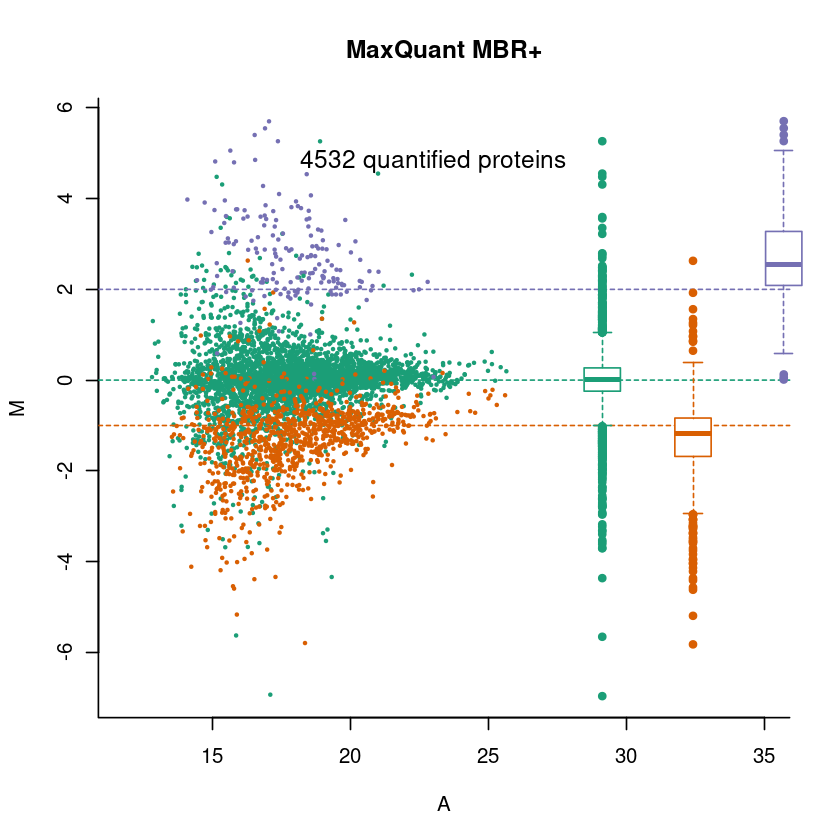

In [11]:
# B vs A 
# par(mfrow=c(1,3))

proteins <- rownames(ygene_mbr)
ident_specs <- rep("HUMAN", nrow(ygene_mbr))
ident_specs[grepl("YEAST", proteins)] <- "YEAST"
ident_specs[grepl("ECOLI", proteins)] <- "ECOLI"

ident_specs <- factor(ident_specs, levels = c("HUMAN","YEAST", "ECOLI"))
uniq_cols <- cols[factor(levels(ident_specs), c("HUMAN","YEAST", "ECOLI"))]
names(uniq_cols) <-  c("HUMAN","YEAST", "ECOLI")


table(ident_specs)

# par(fig=c(0,0.8,0,0))
# M <- rowMeans(ygene[,group=="B"], na.rm = TRUE) - rowMeans(ygene[, group=="A"], na.rm = TRUE)
M <- ygene_mbr[complete.cases(ygene_mbr),5] - ygene_mbr[complete.cases(ygene_mbr), 3]
A <- rowMeans(ygene_mbr[complete.cases(ygene_mbr),], na.rm = TRUE)
# par(fig = c(0,0.95,0,1))
plot(A, M, main = paste("MaxQuant MBR+"), pch = 16, cex = 0.39,
     col=cols_scatter[ident_specs][complete.cases(ygene_mbr)],
     xlim = c(11.8, 35), axes=FALSE, frame.plot=FALSE)

pm1 = par()
box(bty="l")
axis(2)
axis(1)
lines(x= par()$usr[c(1,2)] , y = c(-1,-1), lty=2, col = uniq_cols["YEAST"])
lines(x= par()$usr[c(1,2)] , y = c(0,0), lty=2, col = uniq_cols["HUMAN"])
lines(x= par()$usr[c(1,2)] , y = c(2,2), lty=2, col = uniq_cols["ECOLI"])


# abline(h = -1, lty=2, col = uniq_cols["YEAST"])
# abline(h = 0, lty=2, col = uniq_cols["HUMAN"])
# abline(h = 2, lty=2, col = uniq_cols["ECOLI"])
text(23, 4.8, paste(sum(complete.cases(ygene_mbr)), "quantified proteins"), cex = 1.2)
par(fig=c(0.65,1,0, 1), new=TRUE)
pm = par()$mar
pm[c(2,4)] <- 0
par(mar = pm)
boxplot(
  M[ident_specs[complete.cases(ygene_mbr)] == "HUMAN"],
  M[ident_specs[complete.cases(ygene_mbr)] == "YEAST"],
  M[ident_specs[complete.cases(ygene_mbr)] == "ECOLI"],
  axes = FALSE, border = uniq_cols, 
  col = "white", 
  # ylim = c(-6,5.2),
   ylim = c(-6.9,5.7),
  pch = 20,
  boxwex=0.4
  )




In [12]:
proteins <- rownames(ygene_pip)
ident_specs <- rep("HUMAN", nrow(ygene_pip))
ident_specs[grepl("YEAST", proteins)] <- "YEAST"
ident_specs[grepl("ECOLI", proteins)] <- "ECOLI"

ident_specs <- factor(ident_specs, levels = c("HUMAN","YEAST", "ECOLI"))
uniq_cols <- cols[factor(levels(ident_specs), c("HUMAN","YEAST", "ECOLI"))]
names(uniq_cols) <-  c("HUMAN","YEAST", "ECOLI")


table(ident_specs)


ident_specs
HUMAN YEAST ECOLI 
 4564  1943   540 

#### $k=5$ PIP

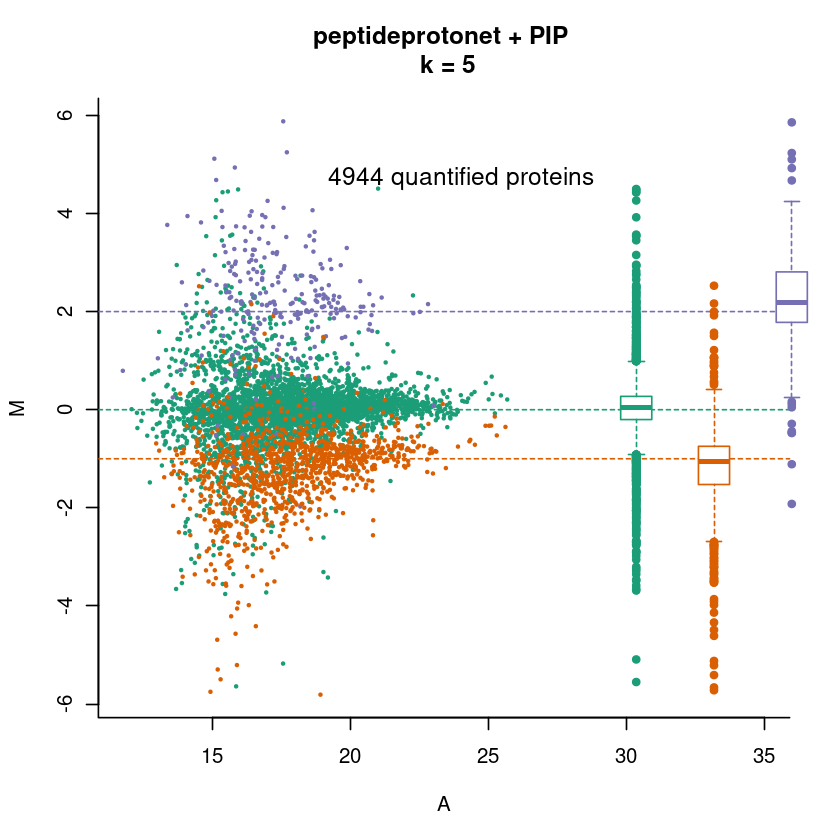

In [13]:
# par(fig=c(0,0.8,0,0))

# M <- rowMeans(ygene_pip[,group=="B"], na.rm = TRUE) - rowMeans(ygene_pip[, group=="A"], na.rm = TRUE)
M <- ygene_pip[complete.cases(ygene_pip),5] - ygene_pip[complete.cases(ygene_pip), 3]
A <- rowMeans(ygene_pip[complete.cases(ygene_pip),], na.rm = TRUE)
plot(A, M, main = paste("peptideprotonet + PIP \n k = 5"), pch = 16, cex = 0.39,
     col=cols_scatter[ident_specs][complete.cases(ygene_pip)],
     axes=FALSE, frame.plot=FALSE, xlim = c(11.8, 35))
pm1 = par()
box(bty="l")
axis(2)
axis(1)

lines(x= pm1$usr[c(1,2)] , y = c(-1,-1), lty=2, col = uniq_cols["YEAST"])
lines(x= pm1$usr[c(1,2)] , y = c(0,0), lty=2, col = uniq_cols["HUMAN"])
lines(x= pm1$usr[c(1,2)] , y = c(2,2), lty=2, col = uniq_cols["ECOLI"])

text(24, 4.7, paste(sum(complete.cases(ygene_pip)), "quantified proteins"), cex = 1.2)
par(fig=c(0.7,1,0, 1), new=TRUE)
pm = par()$mar
pm[c(2,4)] <- 0
par(mar = pm)
boxplot(
  M[ident_specs[complete.cases(ygene_pip)] == "HUMAN"],
  M[ident_specs[complete.cases(ygene_pip)] == "YEAST"],
  M[ident_specs[complete.cases(ygene_pip)] == "ECOLI"],
  axes = FALSE, border = uniq_cols, 
  bg = NULL,
  col = "white", pch = 20, 
  ylim = c(-5.9, 5.9),
  boxwex=0.4
  
  )

#### $k=10$ PIP

In [14]:
z <- computeStats(0.5, k = 10)
m <- z$identifications
m$Intensity <- as.numeric(m$Intensity)
m$PrecursorID <- gsub("_HeLa","", m$PrecursorID)

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_890

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_891

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124A_Slot1-7_1_892

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_893

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_894

20180809_120min_200ms_WEHI25_brute20k_timsON_100ng_HYE124B_Slot1-8_1_895



In [15]:
y_pip <- evidenceToMatrix(m , peptide_id = "PrecursorID")

# remove charge 1 identifications and contaminations
y_pip <- y_pip[grep("_1", rownames(y_pip), invert=TRUE), ]
y_pip <- y_pip[!grepl("CON|REV|character", rownames(y_pip)),]

rownames(y_pip) <- gsub("ECOLI_Ecoli","ECOLI", rownames(y_pip))
rownames(y_pip) <- gsub("Ecoli","ECOLI", rownames(y_pip))



rownames(y_pip) <- gsub("ECOLI_Yeast","YEAST", rownames(y_pip))
rownames(y_pip) <- gsub("Yeast","YEAST", rownames(y_pip))


pIds <- gsub("(.*)_([1-5])_(.*)","\\3", rownames(y_pip))
ygene_pip <- aggregate(.~ ProteinID, FUN=sumTopN, data = data.frame(y_pip, ProteinID = pIds), 
                       na.action = na.pass
                       #na.rm=TRUE, trim = 0.2
                       )
rownames(ygene_pip) <- ygene_pip$ProteinID
ygene_pip$ProteinID <- NULL
ygene_pip[ygene_pip==0] <- NA

ygene_pip <- limma::normalizeBetweenArrays(log2(ygene_pip), method = "quantile")

In [16]:
proteins <- rownames(ygene_pip)
ident_specs <- rep("HUMAN", nrow(ygene_pip))
ident_specs[grepl("YEAST", proteins)] <- "YEAST"
ident_specs[grepl("ECOLI", proteins)] <- "ECOLI"

ident_specs <- factor(ident_specs, levels = c("HUMAN","YEAST", "ECOLI"))
uniq_cols <- cols[factor(levels(ident_specs), c("HUMAN","YEAST", "ECOLI"))]
names(uniq_cols) <-  c("HUMAN","YEAST", "ECOLI")


table(ident_specs)

ident_specs
HUMAN YEAST ECOLI 
 4796  2011   580 

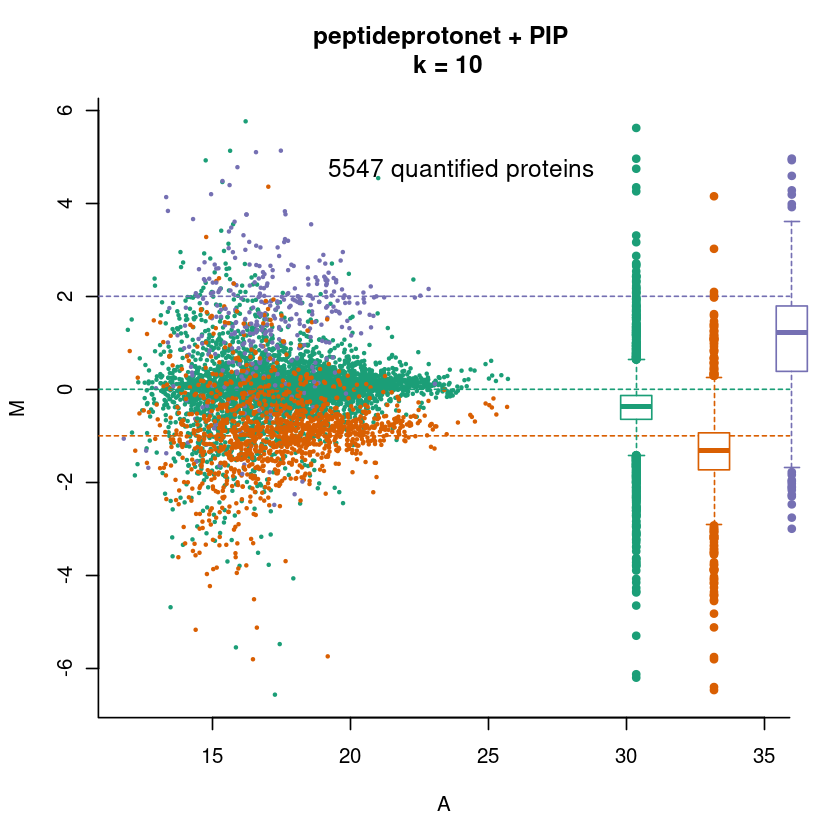

In [17]:
M <- ygene_pip[complete.cases(ygene_pip),5] - ygene_pip[complete.cases(ygene_pip), 3]
A <- rowMeans(ygene_pip[complete.cases(ygene_pip),], na.rm = TRUE)
plot(A, M, main = paste("peptideprotonet + PIP \n k = 10"), pch = 16, cex = 0.39,
     col=cols_scatter[ident_specs][complete.cases(ygene_pip)],
     axes=FALSE, frame.plot=FALSE, xlim = c(11.8, 35))
pm1 = par()
box(bty="l")
axis(2)
axis(1)

lines(x= pm1$usr[c(1,2)] , y = c(-1,-1), lty=2, col = uniq_cols["YEAST"])
lines(x= pm1$usr[c(1,2)] , y = c(0,0), lty=2, col = uniq_cols["HUMAN"])
lines(x= pm1$usr[c(1,2)] , y = c(2,2), lty=2, col = uniq_cols["ECOLI"])

text(24, 4.7, paste(sum(complete.cases(ygene_pip)), "quantified proteins"), cex = 1.2)
par(fig=c(0.7,1,0, 1), new=TRUE)
pm = par()$mar
pm[c(2,4)] <- 0
par(mar = pm)
boxplot(
  M[ident_specs[complete.cases(ygene_pip)] == "HUMAN"],
  M[ident_specs[complete.cases(ygene_pip)] == "YEAST"],
  M[ident_specs[complete.cases(ygene_pip)] == "ECOLI"],
  axes = FALSE, border = uniq_cols, 
  bg = NULL,
  col = "white", pch = 20, 
  ylim = c(-5.9, 5.9),
  boxwex=0.4
  
  )

### Session Information

In [19]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] msImpute_1.7.1

loaded via a namespace (and not attached):
 [1] bitops_1.0-6                matrixStats_0.57.0         
 [3] fs_1.5.0                    usethis_2.0.1              
 [5] devtools_2.4.2              RColorBrewer_1.1-2     